## Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [96]:
#!pip install flask-ngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from numpy.random import seed
seed(1)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import resample
import itertools
import tensorflow as tf
from keras.preprocessing import image

import keras
from keras.applications import ResNet50
from keras.models import Sequential, Model,load_model
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,AveragePooling2D,GlobalMaxPooling2D
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras import regularizers
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
np.random.seed(123)

## CNN Model

In [4]:
lesion_type_dict = {
    'Beng': 'Benign',
    'mel': 'Malignant',
}

#Dictionary for Image Names
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
 for x in glob(os.path.join('/content/drive/MyDrive/SkinLesion_Two_Classes/', '*', '*.jpg'))}
#for x in glob(os.path.join('/mnt/g/My Drive/SkinLesion_7_Classes/', '*', '*.jpg'))}

In [125]:
len(imageid_path_dict)

11614

In [5]:
#Load HAM10000 data
skin_df=pd.read_csv('/content/drive/MyDrive/HAM10000_metadataBinary.csv')

In [6]:
#Create useful Columns - Images Path, Lesion Type and Lesion Categorical Code
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes


In [7]:
#To balanced the data I add Malignant cases fro old ISIC challange and reduced from Benign cases so I remove the nan value fro the path of images
df =skin_df[skin_df['path'].notna()]

In [8]:
#img['image'] = img['path'].map(lambda x: np.asarray(Image.open(x).resize((112,112))))
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((112,112))))

<ipython-input-8-1ee31950f10e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((112,112))))


In [9]:
features=df.drop(columns=['cell_type_idx'],axis=1)
target=df['cell_type_idx']

In [10]:
# Create First Train and Test sets
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=123)

#Splitting training into Train and Validatation sets
x_train, x_validate, y_train, y_validate = train_test_split(x_train_o, y_train_o, test_size = 0.1,random_state=123)


In [11]:
# Balanced Tran Data
#x_train['cell_type_idx']=y_train


In [12]:
#df_0 = x_train[x_train['cell_type_idx'] == 0]
#df_1 = x_train[x_train['cell_type_idx'] == 1]

#n_samples=5000 
#df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
#df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 


In [13]:

#Combined back to a single dataframe
#x_train = pd.concat([df_0_balanced, df_1_balanced])

#Check the data distribution
#print(x_train['cell_type_idx'].value_counts())


In [14]:
#y_train_o=x_train['cell_type_idx']
#x_train_o=x_train.drop(columns=['cell_type_idx'],axis=1)

In [15]:
#The normalisation is done using the training set Mean and Std. Deviation as reference
x_train = np.asarray(x_train['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())
x_validate=np.asarray(x_validate['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_train_mean)/x_train_std
x_validate= (x_validate - x_train_mean)/x_train_std

# Perform one-hot encoding on the labels
y_train = to_categorical(y_train, num_classes = 2)
y_test = to_categorical(y_test_o, num_classes = 2)
y_validate= to_categorical(y_validate, num_classes = 2)

#Reshaping the Images into 3 channels (RGB)
x_train = x_train.reshape(x_train.shape[0], *(112, 112, 3))
x_test = x_test.reshape(x_test.shape[0], *(112, 112, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(112, 112, 3))

In [16]:
# Define some parametersfor the Model
size=(112,112)
num_classes = 2
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
epochs = 50
batch_size = 32
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=0, factor=0.5, min_lr=0.00001)
early_stopping_monitor = EarlyStopping(patience=20,monitor='val_accuracy')

In [17]:
model_checkpoint_callback = ModelCheckpoint(filepath='/content/drive/MyDrive/model_regnet_Binary_balanced_new_drop5.h5',
                                            save_weights_only=False,
                                            monitor='val_accuracy',
                                            mode='auto',
                                            save_best_only=True,
                                            verbose=1)

In [18]:
#Data Augmentation
dataaugment = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        ) 

In [19]:
base_model = tf.keras.applications.RegNetX032(include_top=False, input_shape=(112,112, 3),pooling = 'avg', weights = 'imagenet')

58216992/58216992 [==============================] - 4s 0us/step


In [20]:
RegNetX032model = Sequential()
RegNetX032model.add(base_model)
RegNetX032model.add(Dropout(0.5))
RegNetX032model.add(Dense(num_classes, activation = 'softmax'))

In [23]:

RegNetX032model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
history = RegNetX032model.fit(dataaugment.flow(x_train,y_train, batch_size=batch_size),
                        epochs = epochs, validation_data = (x_validate,y_validate),
                        verbose = 0, steps_per_epoch=x_train.shape[0] // batch_size, 
                        callbacks=[learning_rate_reduction,early_stopping_monitor,model_checkpoint_callback])


Epoch 1: val_accuracy improved from -inf to 0.84624, saving model to /content/drive/MyDrive/model_regnet_Binary_balanced_new_dropout.h5

Epoch 2: val_accuracy did not improve from 0.84624

Epoch 3: val_accuracy did not improve from 0.84624

Epoch 4: val_accuracy improved from 0.84624 to 0.86129, saving model to /content/drive/MyDrive/model_regnet_Binary_balanced_new_dropout.h5

Epoch 5: val_accuracy did not improve from 0.86129

Epoch 6: val_accuracy did not improve from 0.86129

Epoch 7: val_accuracy did not improve from 0.86129

Epoch 8: val_accuracy did not improve from 0.86129

Epoch 9: val_accuracy did not improve from 0.86129

Epoch 10: val_accuracy improved from 0.86129 to 0.86667, saving model to /content/drive/MyDrive/model_regnet_Binary_balanced_new_dropout.h5

Epoch 11: val_accuracy improved from 0.86667 to 0.87849, saving model to /content/drive/MyDrive/model_regnet_Binary_balanced_new_dropout.h5

Epoch 12: val_accuracy improved from 0.87849 to 0.87957, saving model to /co

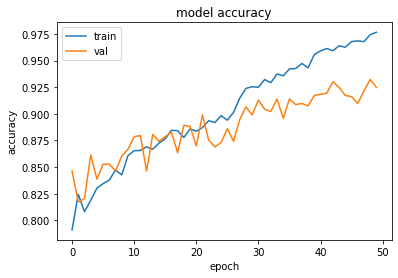

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

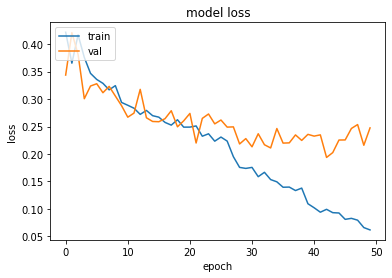

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [26]:
#Building a report 
predictions = (RegNetX032model.predict(x_test) > 0.5).astype("int32")

73/73 [==============================] - 4s 36ms/step


In [27]:
predictions_train = (RegNetX032model.predict(x_train) > 0.5).astype("int32")

262/262 [==============================] - 10s 39ms/step


In [28]:
predictions_validate = (RegNetX032model.predict(x_validate) > 0.5).astype("int32")

30/30 [==============================] - 1s 36ms/step


In [30]:
print(classification_report(y_test, predictions, target_names=['Benign','Malignant'],digits=4  ))


              precision    recall  f1-score   support

      Benign     0.9488    0.9048    0.9263      1229
   Malignant     0.8983    0.9452    0.9212      1094

   micro avg     0.9238    0.9238    0.9238      2323
   macro avg     0.9236    0.9250    0.9237      2323
weighted avg     0.9250    0.9238    0.9239      2323
 samples avg     0.9238    0.9238    0.9238      2323



In [31]:
print(classification_report(y_train, predictions_train, target_names=['Benign','Malignant'], digits=4 ))

              precision    recall  f1-score   support

      Benign     0.9920    0.9799    0.9859      4284
   Malignant     0.9792    0.9917    0.9854      4077

   micro avg     0.9856    0.9856    0.9856      8361
   macro avg     0.9856    0.9858    0.9856      8361
weighted avg     0.9857    0.9856    0.9856      8361
 samples avg     0.9856    0.9856    0.9856      8361



In [32]:
print(classification_report(y_validate, predictions_validate, target_names=['Benign','Malignant'],digits=4 ))

              precision    recall  f1-score   support

      Benign     0.9500    0.8970    0.9227       466
   Malignant     0.9020    0.9526    0.9266       464

   micro avg     0.9247    0.9247    0.9247       930
   macro avg     0.9260    0.9248    0.9247       930
weighted avg     0.9261    0.9247    0.9247       930
 samples avg     0.9247    0.9247    0.9247       930



In [33]:
print(confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1)))

[[1112  117]
 [  60 1034]]


In [34]:
print(confusion_matrix(y_train.argmax(axis=1), predictions_train.argmax(axis=1)))

[[4198   86]
 [  34 4043]]


In [35]:
print(confusion_matrix(y_validate.argmax(axis=1), predictions_validate.argmax(axis=1)))

[[418  48]
 [ 22 442]]


In [36]:
#best_model = load_model('/content/drive/MyDrive/model_regnet.h5')